# Tables & Figures Generation

[![Binder](https://notebooks.gesis.org/binder/badge_logo.svg)](https://notebooks.gesis.org/binder/v2/gh/AyrtonB/Merit-Order-Effect/main?filepath=nbs%2Fdev-09-tables-and-figures.ipynb)

This notebook provides a programmatic workflow for generating the tables used in the MOE paper, as well as the diagram to show the time-adaptive smoothing weights.

<br>

### Imports

In [33]:
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from IPython.display import Latex, JSON

from moepy import eda, lowess

<br>

### Tables

##### Power Systems Overview

We'll first load in the DE data

In [2]:
df_DE = eda.load_DE_df('../data/energy_charts.csv', '../data/ENTSOE_DE_price.csv')

df_DE.head()

,Biomass,Brown Coal,Gas,Hard Coal,Hydro Power,Oil,Others,Pumped Storage,Seasonal Storage,Solar,Uranium,Wind,net_balance,demand,price
local_datetime,,,,,,,,,,,,,,,
2010-01-03 23:00:00+00:00,3.637,16.533,4.726,10.078,2.331,0.000,0.0,0.052,0.068,0.0,16.826,0.635,-1.229,53.657,NaN
2010-01-04 00:00:00+00:00,3.637,16.544,4.856,8.816,2.293,0.000,0.0,0.038,0.003,0.0,16.841,0.528,-1.593,51.963,NaN
2010-01-04 01:00:00+00:00,3.637,16.368,5.275,7.954,2.299,0.000,0.0,0.032,0.000,0.0,16.846,0.616,-1.378,51.649,NaN
2010-01-04 02:00:00+00:00,3.637,15.837,5.354,7.681,2.299,0.000,0.0,0.027,0.000,0.0,16.699,0.630,-1.624,50.540,NaN
2010-01-04 03:00:00+00:00,3.637,15.452,5.918,7.498,2.301,0.003,0.0,0.020,0.000,0.0,16.635,0.713,-0.731,51.446,NaN


<br>

Clean it up then calculate the relevant summary statistics

In [3]:
s_DE_RES_output = df_DE[['Wind', 'Solar']].sum(axis=1)
s_DE_demand = df_DE['demand']
s_DE_price = df_DE['price']

s_DE_RES_pct = s_DE_RES_output/s_DE_demand

DE_2020_RES_pct = s_DE_RES_pct['2020'].mean()
DE_2020_demand_avg = s_DE_demand['2020'].mean()
DE_2020_price_avg = s_DE_price['2020'].mean()

DE_2020_RES_pct, DE_2020_demand_avg, DE_2020_price_avg

(0.3593124152992342, 55.956133452868855, 30.469415917112606)

<br>

We'll also estimate the carbon intensity

In [4]:
DE_fuel_to_co2_intensity = {
    'Biomass': 0.39, 
    'Brown Coal': 0.36, 
    'Gas': 0.23, 
    'Hard Coal': 0.34, 
    'Hydro Power': 0, 
    'Oil': 0.28,
    'Others': 0, 
    'Pumped Storage': 0, 
    'Seasonal Storage': 0, 
    'Solar': 0, 
    'Uranium': 0,
    'Wind': 0, 
    'net_balance': 0 
}

s_DE_emissions_tonnes = (df_DE
                         [DE_fuel_to_co2_intensity.keys()]
                         .multiply(1e3) # converting to MWh
                         .multiply(DE_fuel_to_co2_intensity.values())
                         .sum(axis=1)
                        )

s_DE_emissions_tonnes = s_DE_emissions_tonnes[s_DE_emissions_tonnes>2000]
s_DE_carbon_intensity = s_DE_emissions_tonnes/s_DE_demand.loc[s_DE_emissions_tonnes.index]

DE_2020_emissions_tonnes = s_DE_emissions_tonnes['2020'].mean()
DE_2020_ci_avg = s_DE_carbon_intensity['2020'].mean()

DE_2020_emissions_tonnes, DE_2020_ci_avg

(8448.292069623136, 153.80385402105972)

<br>

We'll do the same for GB

In [5]:
# Loading in
df_EI = pd.read_csv('../data/electric_insights.csv')

df_EI = df_EI.set_index('local_datetime')
df_EI.index = pd.to_datetime(df_EI.index, utc=True)

# Extracting RES, demand, and price series
s_GB_RES = df_EI[['wind', 'solar']].sum(axis=1)
s_GB_demand = df_EI['demand']
s_GB_price = df_EI['day_ahead_price']

# Generating carbon intensity series
GB_fuel_to_co2_intensity = {
    'nuclear': 0, 
    'biomass': 0.121, # from EI 
    'coal': 0.921, # DUKES 2018 value
    'gas': 0.377, # DUKES 2018 value (lower than many CCGT estimates, let alone OCGT)
    'hydro': 0, 
    'pumped_storage': 0, 
    'solar': 0,
    'wind': 0,
    'belgian': 0.4,  
    'dutch': 0.474, # from EI 
    'french': 0.053, # from EI 
    'ireland': 0.458, # from EI 
    'northern_ireland': 0.458 # from EI 
}

s_GB_emissions_tonnes = (df_EI
                         [GB_fuel_to_co2_intensity.keys()]
                         .multiply(1e3*0.5) # converting to MWh
                         .multiply(GB_fuel_to_co2_intensity.values())
                         .sum(axis=1)
                        )

s_GB_emissions_tonnes = s_GB_emissions_tonnes[s_GB_emissions_tonnes>2000]
s_GB_carbon_intensity = s_GB_emissions_tonnes/s_GB_demand.loc[s_GB_emissions_tonnes.index]

# Calculating 2020 averages
GB_2020_emissions_tonnes = s_GB_emissions_tonnes['2020'].mean()
GB_2020_ci_avg = s_GB_carbon_intensity['2020'].mean()
GB_2020_RES_pct = (s_GB_RES['2020']/s_GB_demand['2020']).mean()
GB_2020_demand_avg = s_GB_demand['2020'].mean()
GB_2020_price_avg = s_GB_price['2020'].mean()

<br>

Then combine the results in a single table

In [6]:
system_overview_data = {
    'Germany': {
        'Average Solar/Wind Generation (%)': round(100*DE_2020_RES_pct, 2),
        'Average Demand (GW)': round(DE_2020_demand_avg, 2),
        'Average Price ([EUR,GBP]/MWh)': round(DE_2020_price_avg, 2),
        'Average Carbon Intensity  (gCO2/kWh)': round(DE_2020_ci_avg, 2),
    },
    'Great Britain': {
        'Average Solar/Wind Generation (%)': round(100*GB_2020_RES_pct, 2),
        'Average Demand (GW)': round(GB_2020_demand_avg, 2),
        'Average Price ([EUR,GBP]/MWh)': round(GB_2020_price_avg, 2),
        'Average Carbon Intensity  (gCO2/kWh)': round(GB_2020_ci_avg, 2),
    }
}

df_system_overview = pd.DataFrame(system_overview_data).T

df_system_overview.head()

,Average Solar/Wind Generation (%),Average Demand (GW),"Average Price ([EUR,GBP]/MWh)",Average Carbon Intensity (gCO2/kWh)
Germany,35.93,55.96,30.47,153.80
Great Britain,29.83,30.61,33.77,101.17


<br>

Which we'll then output as a LaTeX table

In [7]:
get_lined_column_format = lambda n_cols:''.join(n_cols*['|l']) + '|'

caption = 'Systems overview for 2020'
label = 'overview_table'
column_format = get_lined_column_format(df_system_overview.shape[1]+1)

latex_str = df_system_overview.to_latex(column_format=column_format, caption=caption, label=label)

latex_replacements = {
    'CO2': 'CO\\textsubscript{2}',
    '\\\\\n': '\\\\ \\midrule\n',
    'midrule': 'hline',
    'toprule': 'hline',
    'bottomrule': '',
    '\n\\\n': '\n',
    '\\hline\n\\hline': '\\hline'
}

for old, new in latex_replacements.items():
    latex_str = latex_str.replace(old, new)

Latex(latex_str)

<IPython.core.display.Latex object>

<br>

##### Carbon Intensity Estimates

We'll clean up our GB carbon intensity estimates

In [8]:
def clean_idxs(s):
    s.index = s.index.str.replace('_', ' ').str.title()
    return s

df_GB_non0_co2_intensity = (pd
                            .Series(GB_fuel_to_co2_intensity)
                            .replace(0, np.nan)
                            .dropna()
                            .drop(['belgian', 'northern_ireland'])
                            .pipe(clean_idxs)
                            .multiply(1e3)
                            .astype(int)
                            .to_frame()
                            .T
                            .rename({0: 'gCO2/kWh'})
                           )

df_GB_non0_co2_intensity

,Biomass,Coal,Gas,Dutch,French,Ireland
gCO2/kWh,121,921,377,474,53,458


<br>

And output them as a LaTeX table

In [9]:
caption = 'Carbon intensity factors for fuel-types and interconnection on the GB power system'
label = 'GB_co2_intensity_table'
column_format = get_lined_column_format(df_GB_non0_co2_intensity.shape[1]+1)

latex_str = df_GB_non0_co2_intensity.to_latex(column_format=column_format, caption=caption, label=label)

latex_replacements = {
    'CO2': 'CO\\textsubscript{2}',
    '\\\\\n': '\\\\ \\midrule\n',
    'midrule': 'hline',
    'toprule': 'hline',
    'bottomrule': '',
    '\n\\\n': '\n',
    '\\hline\n\\hline': '\\hline'
}

for old, new in latex_replacements.items():
    latex_str = latex_str.replace(old, new)

Latex(latex_str)

<IPython.core.display.Latex object>

<br>

We'll then do the same for DE

In [10]:
df_DE_non0_co2_intensity = (pd
                            .Series(DE_fuel_to_co2_intensity)
                            .replace(0, np.nan)
                            .dropna()
                            [['Biomass', 'Brown Coal', 'Hard Coal', 'Gas', 'Oil']]
                            .pipe(clean_idxs)
                            .multiply(1e3)
                            .astype(int)
                            .to_frame()
                            .T
                            .rename({0: 'gCO2/kWh'})
                           )

df_DE_non0_co2_intensity

,Biomass,Brown Coal,Hard Coal,Gas,Oil
gCO2/kWh,390,360,340,230,280


In [11]:
caption = 'Carbon intensity factors for fuel-types and interconnection on the DE power system'
label = 'DE_co2_intensity_table'
column_format = get_lined_column_format(df_DE_non0_co2_intensity.shape[1]+1)

latex_str = df_DE_non0_co2_intensity.to_latex(column_format=column_format, caption=caption, label=label)

for old, new in latex_replacements.items():
    latex_str = latex_str.replace(old, new)

Latex(latex_str)

<IPython.core.display.Latex object>

<br>

##### Electricity Price Forecasting Metrics

We'll start by loading in our previously saved model metrics

In [12]:
with open('../data/results/price_model_accuracy_metrics.json', 'r') as fp:
    model_accuracy_metrics = json.load(fp)
    
JSON(model_accuracy_metrics)

<IPython.core.display.JSON object>

<br>

We'll parse the MAE results into a new table

In [13]:
model_accuracy_data = {
    'Germany': {
        'Dispatchable Load': round(model_accuracy_metrics['DE_dispatch']['mean_abs_err'], 2),
        'Total Load': round(model_accuracy_metrics['DE_demand']['mean_abs_err'], 2),
    },
    'Great Britain': {
        'Dispatchable Load': round(model_accuracy_metrics['GB_dispatch']['mean_abs_err'], 2),
        'Total Load': round(model_accuracy_metrics['GB_demand']['mean_abs_err'], 2),
    }
}

df_model_accuracy = pd.DataFrame(model_accuracy_data).T

df_model_accuracy.head()

,Dispatchable Load,Total Load
Germany,5.85,18.28
Great Britain,6.56,8.42


<br>

Which we'll output as a LaTeX table

In [14]:
caption = 'Price forecasting model accuracy when regressing against dispatchable and total load for GB and DE.'
label = 'model_accuracy_table'
column_format = get_lined_column_format(df_model_accuracy.shape[1]+1)

latex_str = df_model_accuracy.to_latex(column_format=column_format, caption=caption, label=label)

for old, new in latex_replacements.items():
    latex_str = latex_str.replace(old, new)

Latex(latex_str)

<IPython.core.display.Latex object>

<br>

##### Price and CO2 MOE Results

We'll first load in all of the price and carbon MOE time-series

In [15]:
def set_dt_idx(df, dt_idx_col='local_datetime'):
    df = df.set_index(dt_idx_col)
    df.index = pd.to_datetime(df.index, utc=True)
    
    return df

df_GB_price_results_ts = pd.read_csv('../data/results/GB_price.csv').pipe(set_dt_idx)
df_DE_price_results_ts = pd.read_csv('../data/results/DE_price.csv').pipe(set_dt_idx)
df_GB_carbon_results_ts = pd.read_csv('../data/results/GB_carbon.csv').pipe(set_dt_idx)
df_DE_carbon_results_ts = pd.read_csv('../data/results/DE_carbon.csv').pipe(set_dt_idx)

df_GB_price_results_ts.head()

,prediction,counterfactual,observed,moe
local_datetime,,,,
2009-01-01 00:00:00+00:00,37.203441,37.313379,58.05,0.109938
2009-01-01 00:30:00+00:00,37.313379,37.535135,56.33,0.221756
2009-01-01 01:00:00+00:00,36.768513,36.985087,52.98,0.216574
2009-01-01 01:30:00+00:00,35.595162,35.807631,50.39,0.212469
2009-01-01 02:00:00+00:00,34.849422,35.063119,48.70,0.213697


<br>

We'll then calculate their summary statistics

In [16]:
MOE_results_data = {
    'Germany': {
        'Price ([EUR,GBP]/MWh)': round(df_DE_price_results_ts.loc['2020', 'moe'].mean(), 2),
        'Price (%)': round(100*(df_DE_price_results_ts.loc['2020', 'moe']*df_DE['demand']).sum()/((df_DE_price_results_ts.loc['2020', 'observed']+df_DE_price_results_ts.loc['2020', 'moe'])*df_DE['demand']).sum(), 2),
        'Carbon (Tonnes/h)': round(df_DE_carbon_results_ts.loc['2020', 'moe'].mean(), 2),
        'Carbon (%)': round(100*(df_DE_carbon_results_ts.loc['2020', 'moe'].sum()/(df_DE_carbon_results_ts.loc['2020', 'observed']+df_DE_carbon_results_ts.loc['2020', 'moe']).sum()).mean(), 2)
    },
    'Great Britain': {
        'Price ([EUR,GBP]/MWh)': round(df_GB_price_results_ts.loc['2020', 'moe'].mean(), 2),
        'Price (%)': round(100*(df_GB_price_results_ts.loc['2020', 'moe']*df_EI['demand']).sum()/((df_GB_price_results_ts.loc['2020', 'observed']+df_GB_price_results_ts.loc['2020', 'moe'])*df_EI['demand']).sum(), 2),
        'Carbon (Tonnes/h)': round(df_GB_carbon_results_ts.loc['2020', 'moe'].mean(), 2), # doubled to make it the same hourly rate as DE
        'Carbon (%)': round(100*(df_GB_carbon_results_ts.loc['2020', 'moe'].sum()/(df_GB_carbon_results_ts.loc['2020', 'observed']+df_GB_carbon_results_ts.loc['2020', 'moe']).sum()).mean(), 2)
    }
}

df_MOE_results = (pd
                  .DataFrame(MOE_results_data)
                 )

df_MOE_results.head()

,Germany,Great Britain
"Price ([EUR,GBP]/MWh)",22.17,13.89
Price (%),43.43,29.66
Carbon (Tonnes/h),5563.22,1657.88
Carbon (%),39.70,37.89


<br>

And export the output as a LaTeX table

In [17]:
caption = '2020 Merit Order Effect results overview (weighted by volume).'
label = 'moe_results_table'
column_format = get_lined_column_format(df_MOE_results.shape[1]+1)

latex_str = df_MOE_results.to_latex(column_format=column_format, caption=caption, label=label)

for old, new in latex_replacements.items():
    latex_str = latex_str.replace(old, new)

Latex(latex_str)

<IPython.core.display.Latex object>

<br>

##### Literature Review

Lastly we'll create our largest table, containing results from across the literature

In [18]:
lit_results_data = [
    {
        'Study': 'Sensfuss et al. (2008)',
        'MOE': '7.83 €/MWh',
        'Period': '2006',
        'Region': 'Germany',
        'Method': 'ESS',
    },
    {
        'Study': 'Weigt (2009)',
        'MOE': '10 €/MWh',
        'Period': '2006-2008',
        'Region': 'Germany',
        'Method': 'ESS',
    },
    {
        'Study': 'Keles et al. (2013)',
        'MOE': '5.90 €/MWh',
        'Period': '2006–2009',
        'Region': 'Germany',
        'Method': 'RPR',
    },
    {
        'Study': 'Mulder and Scholtens (2013)',
        'MOE': '0.03% price decrease per p.p increase in wind speeds',
        'Period': '2006–2011',
        'Region': 'Germany',
        'Method': 'RPR',
    },
    {
        'Study': 'Tveten et al. (2013)',
        'MOE': '5.25 €/MWh (solar)',
        'Period': '2006-2011',
        'Region': 'Germany',
        'Method': 'RPR',
    },
    {
        'Study': 'Wurzburg et al. (2013)',
        'MOE': '2% price decrease',
        'Period': '2010-2012',
        'Region': 'Germany & Austria',
        'Method': 'RPR',
    },
    {
        'Study': 'Cludius et al. (2014)',
        'MOE': '8 €/MWh',
        'Period': '2010-2012',
        'Region': 'Germany',
        'Method': 'RPR',
    },
    {
        'Study': 'Ketterer (2014)',
        'MOE': '0.1-1.46% price decrease per p.p increase in wind generation',
        'Period': '2006-2012',
        'Region': 'Germany',
        'Method': 'RPR',
    },
    {
        'Study': 'Ederer (2015)',
        'MOE': '1.3% price decrease per annual TWh of wind',
        'Period': '2006-2014',
        'Region': 'Germany',
        'Method': 'MSS',
    },
    {
        'Study': 'Kyritsis et al. (2017)',
        'MOE': '-',
        'Period': '2010-2015',
        'Region': 'Germany',
        'Method': 'RPR',
    },
    {
        'Study': 'Bublitz et al. (2017)',
        'MOE': '5.40 €/MWh',
        'Period': '2011-2015',
        'Region': 'Germany',
        'Method': 'ESS',
    },
    {
        'Study': 'Bublitz et al. (2017)',
        'MOE': '6.80 €/MWh',
        'Period': '2011-2015',
        'Region': 'Germany',
        'Method': 'RPR',
    },
    {
        'Study': 'de Miera et al. (2008)',
        'MOE': '8.6-25.1% price decrease',
        'Period': '2005-2007',
        'Region': 'Spain',
        'Method': 'ESS',
    },
    {
        'Study': 'Gelabert et al. (2011)',
        'MOE': '3.7% price decrease',
        'Period': '2005-2012',
        'Region': 'Spain',
        'Method': 'RPR',
    },
    {
        'Study': 'Ciarreta et al. (2014)',
        'MOE': '25-45 €/MWh',
        'Period': '2008–2012',
        'Region': 'Spain',
        'Method': 'ESS',
    },
    {
        'Study': 'Clo et al. (2015)',
        'MOE': '2.3 €/MWh (solar), 4.2 €/MWh (wind)',
        'Period': '2005–2013',
        'Region': 'Italy',
        'Method': 'RPR',
    },
    {
        'Study': 'Munksgaard and Morthorst (2008)',
        'MOE': '1-4 €/MWh',
        'Period': '2004-2006',
        'Region': 'Denmark',
        'Method': 'RPR',
    },
    {
        'Study': 'Jonsson et al. (2010)',
        'MOE': '-',
        'Period': '2006-2007',
        'Region': 'Denmark',
        'Method': 'RPR',
    },
    {
        'Study': 'Denny et al. (2017)',
        'MOE': '3.40 €/MWh per GWh (wind)',
        'Period': '2009',
        'Region': 'Ireland',
        'Method': 'RPR',
    },
    {
        'Study': 'Lunackova et al. (2017)',
        'MOE': '1.2% price decrease per 10% increase in RES',
        'Period': '2010-2015',
        'Region': 'Czech Republic',
        'Method': 'RPR',
    },
    {
        'Study': 'Dillig et al. (2016)',
        'MOE': '50.29 €/MWh',
        'Period': '2011-2013',
        'Region': 'Germany',
        'Method': 'MSS',
    },
    {
        'Study': 'McConnell et al. (2013)',
        'MOE': '8.6% price decrease',
        'Period': '2009-2010',
        'Region': 'Australia',
        'Method': 'MSS',
    },
    {
        'Study': 'Moreno et al. (2012)',
        'MOE': '0.018% price increase per p.p. increase in RES penetration',
        'Period': '1998–2009',
        'Region': 'EU-27',
        'Method': 'RPR',
    },
    {
        'Study': 'Woo et al. (2011)',
        'MOE': '0.32-1.53 $/MWh',
        'Period': '2007-2010',
        'Region': 'Texas',
        'Method': 'RPR',
    },
    {
        'Study': 'Kaufmann and Vaid (2016)',
        'MOE': '0.26-1.86 $/MWh (solar)',
        'Period': '2010-2012',
        'Region': 'Massachusetts',
        'Method': 'RPR',
    },
    {
        'Study': 'Woo et al. (2016)',
        'MOE': '5.3 \$/MWh (solar) and 3.3 \$/MWh (wind) per GWh of RES',
        'Period': '2012-2015',
        'Region': 'California',
        'Method': 'RPR',
    },
    {
        'Study': 'Paraschiv et al. (2014)',
        'MOE': '0.15% price decrease per MWh of RES',
        'Period': '2010-2013',
        'Region': 'Germany',
        'Method': 'RPR',
    },
    {
        'Study': 'O\'Mahoney and Denny (2011)',
        'MOE': '12% price decrease',
        'Period': '2009',
        'Region': 'Ireland',
        'Method': 'RPR',
    },
    {
        'Study': 'Hildmann et al. (2015)',
        'MOE': '13.4-18.6 €/MWh',
        'Period': '2011-2013',
        'Region': 'Germany and Austria',
        'Method': 'MSS',
    },
    {
        'Study': 'Gil et al. (2012)',
        'MOE': '9.72 €/MWh',
        'Period': '2007-2010',
        'Region': 'Spain',
        'Method': 'RPR',
    },
#     { # Removed due to language barrier preventing method from being discerned
#         'Study': 'Weber and Woll (2007)',
#         'MOE': '4 €/MWh',
#         'Period': '2006',
#         'Region': 'Germany',
#         'Method': '-',
#     },
    {
        'Study': 'Halttunen et al. (2021)',
        'MOE': '0.631 €/MWh per p.p. increase in RES penetration',
        'Period': '2012-2019',
        'Region': 'Germany',
        'Method': 'RPR',
    },
    {
        'Study': 'Halttunen et al. (2021)',
        'MOE': '0.482 €/MWh per p.p. increase in RES penetration',
        'Period': '2010-2019',
        'Region': 'Germany',
        'Method': 'RPR',
    }
]

df_lit_results = pd.DataFrame(lit_results_data)

df_lit_results['Study Year'] = df_lit_results['Study'].str.split('(').str[1].str.replace(')', '').astype(int)
df_lit_results = df_lit_results.sort_values(['Method', 'Study Year', 'Study']).drop(columns=['Study Year']).reset_index(drop=True)

df_lit_results.head()

<ipython-input-18-9abcc44159e6>:237: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_lit_results['Study Year'] = df_lit_results['Study'].str.split('(').str[1].str.replace(')', '').astype(int)


,Study,MOE,Period,Region,Method
0,Sensfuss et al. (2008),7.83 €/MWh,2006,Germany,ESS
1,de Miera et al. (2008),8.6-25.1% price decrease,2005-2007,Spain,ESS
2,Weigt (2009),10 €/MWh,2006-2008,Germany,ESS
3,Ciarreta et al. (2014),25-45 €/MWh,2008–2012,Spain,ESS
4,Bublitz et al. (2017),5.40 €/MWh,2011-2015,Germany,ESS


<br>

We'll also export this as a LaTeX table

In [19]:
caption = 'Results overview from the MOE literature'
label = 'lit_results_table'
column_format = get_lined_column_format(df_lit_results.shape[1]+1)

latex_str = df_lit_results.to_latex(column_format=column_format, caption=caption, label=label, index=False)

for old, new in latex_replacements.items():
    latex_str = latex_str.replace(old, new)

Latex(latex_str)

<IPython.core.display.Latex object>

<br>

### Figures

##### Time Dimension Hyper-Parameters

We'll create a plot showing an example of how regression dates are converted into weightings for the time-series

Text(0, 0.5, 'Relative Weighting')

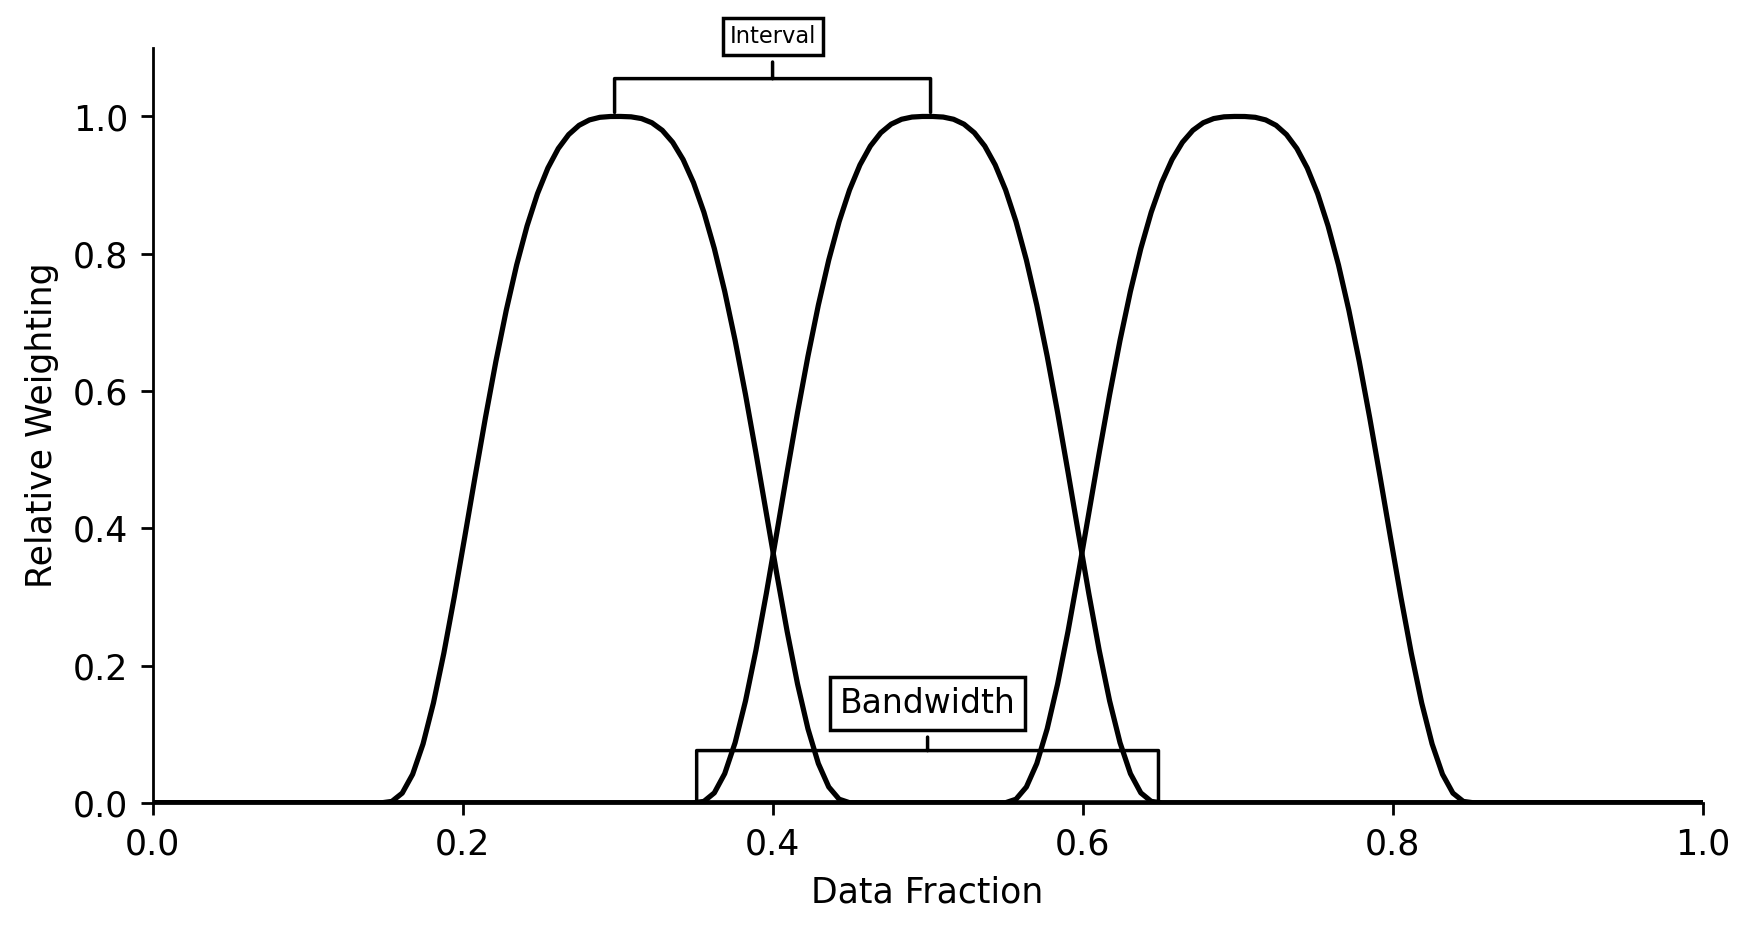

In [86]:
x = np.linspace(0, 1, 150)
centers = [0.3, 0.5, 0.7]

# Plotting
fig, ax = plt.subplots(dpi=250, figsize=(8, 4))

for center in centers:
    dist = lowess.get_dist(x, center)
    dist_threshold = lowess.get_dist_threshold(dist, frac=0.3)
    weights = lowess.dist_to_weights(dist, dist_threshold)

    ax.plot(x, weights, color='k')
    
x_pos = 0.4
ax.annotate('Interval', xy=(x_pos, 0.95), xytext=(x_pos, 1.00), xycoords='axes fraction', 
            fontsize=6.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=7.0, lengthB=1.5', lw=1.0))
    
x_pos = 0.5
ax.annotate('Bandwidth', xy=(x_pos, 0.06), xytext=(x_pos, 0.11), xycoords='axes fraction', 
            fontsize=9.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=7.0, lengthB=1.5', lw=1.0))

ax.set_xlim(0, 1)
ax.set_ylim(0, 1.1)
eda.hide_spines(ax)
ax.set_xlabel('Data Fraction')
ax.set_ylabel('Relative Weighting')